In [15]:
import logging
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List, cast

import matplotlib
import matplotlib.legend
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

log = logging.getLogger(__name__)

TEST_DATASET = [
    "sun397",
    "stanford-cars",
    "resisc45",
    "eurosat",
    "svhn",
    "gtsrb",
    "mnist",
    "dtd",
]
TEST_DATASET_LABELS = [
    "SUN397",
    "Cars",
    "RESISC45",
    "EuroSAT",
    "SVHN",
    "GTSRB",
    "MNIST",
    "DTD",
]

sns.set_theme(style="darkgrid")
color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
# sns.set_palette("bright")

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

In [11]:
# load data from data directory
from fusion_bench.constants import PROJECT_ROOT_PATH

directory = (
    PROJECT_ROOT_PATH / "outputs/layer_wise_routing_weights/clip-vit-base-patch32_TA8"
)
num_layers = 12

all_data = []
for task in tqdm(TEST_DATASET):
    for layer_idx in range(num_layers):
        data = torch.load(
            directory / task / f"layer_{layer_idx}.pt",
            map_location="cpu",
            weights_only=True,
        )  # num_samples, num_token, num_experts
        data = data.mean(dim=1)  # num_samples, num_experts
        # each cloumn is a expert
        data = {TEST_DATASET[i]: data[:, i].numpy() for i in range(data.shape[1])}
        data = pd.DataFrame(data)
        data["layer_idx"] = layer_idx
        data["task"] = task
        all_data.append(data)
all_data = pd.concat(all_data)

100%|██████████| 8/8 [00:00<00:00,  8.08it/s]


100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


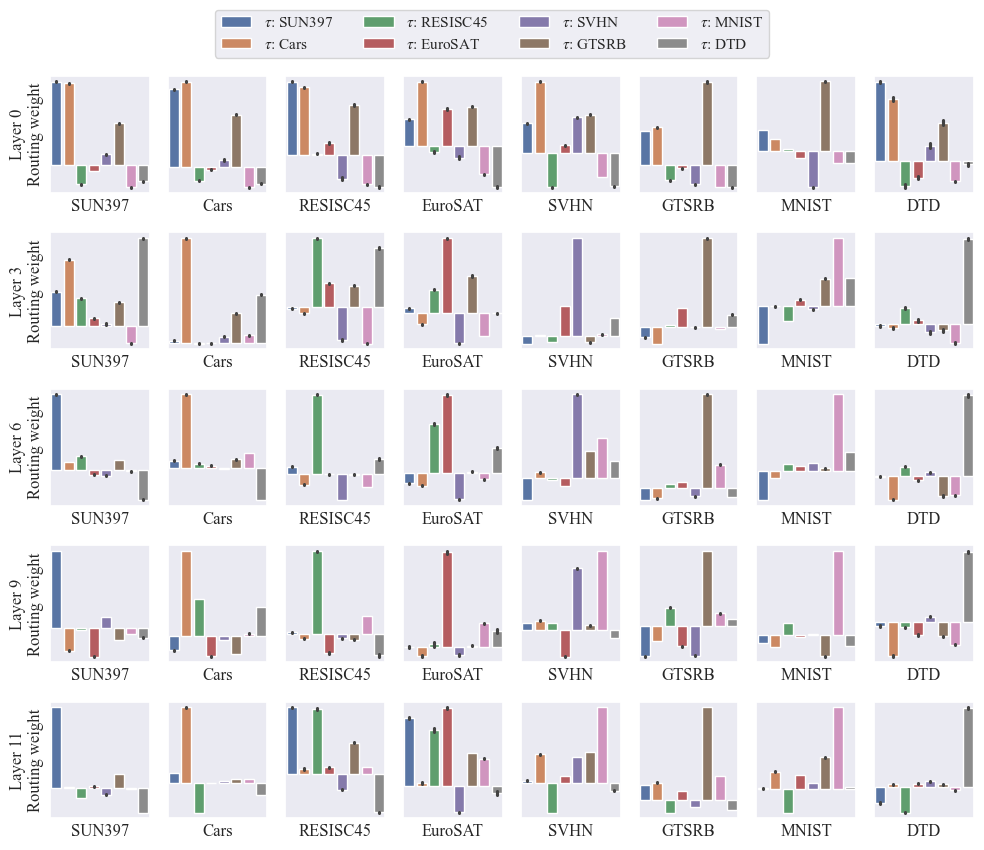

In [9]:
def plot_layer(layer_idx: int, axes: List[plt.Axes]):
    routing_weights = all_data[all_data["layer_idx"] == layer_idx]
    # axes[0].set_ylabel(f"Layer {layer_idx}")
    for task_id, task_name in enumerate(TEST_DATASET):
        task_routing_weights = routing_weights[routing_weights["task"] == task_name]
        task_routing_weights = task_routing_weights.drop(columns=["layer_idx", "task"])
        ax = axes[task_id]
        ax.set_xlabel(TEST_DATASET_LABELS[task_id])
        sns.barplot(data=task_routing_weights, ax=ax, label=task_name)
        if task_id == 0:
            ax.set_ylabel(f"Layer {layer_idx}\nRouting weight")
        ax.set_yticks([])
        ax.set_xticks([])


fig, axes = plt.subplots(5, 8, figsize=(10, 8))

for axes_row_idx, layer_idx in enumerate(tqdm([0, 3, 6, 9, 11])):
    plot_layer(layer_idx, axes[axes_row_idx])

handles, labels = axes[0][0].get_legend_handles_labels()
labels = [rf"$\tau$: {TEST_DATASET_LABELS[i]}" for i in range(8) if i < len(labels)]
fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.07))

plt.tight_layout()

plt.savefig("routing_analysis.pdf", bbox_inches="tight")
plt.show()

In [12]:
def first_choice_prob(task_id: int, layer_idx: int):
    routing_weights = all_data[
        (all_data["layer_idx"] == layer_idx)
        & (all_data["task"] == TEST_DATASET[task_id])
    ]
    routing_weights = routing_weights.drop(columns=["layer_idx", "task"])
    routing_weights = np.array(routing_weights)
    prob = (routing_weights.argmax(axis=1) == task_id).sum() / routing_weights.shape[0]
    return prob


first_choice_prob_matrix = np.zeros((len(TEST_DATASET), num_layers))
for task_id in range(len(TEST_DATASET)):
    for layer_idx in range(num_layers):
        first_choice_prob_matrix[task_id, layer_idx] = first_choice_prob(
            task_id, layer_idx
        )
display(first_choice_prob_matrix)

array([[0.44881612, 0.45571788, 0.00156171, 0.02942065, 0.08277078,
        0.55924433, 0.90967254, 0.94367758, 0.94680101, 0.94473552,
        0.9915869 , 0.99138539],
       [0.55652282, 0.57828628, 0.83099117, 0.88869544, 0.96953115,
        0.99490113, 0.99303569, 0.97525183, 0.99054844, 0.96580027,
        0.88036314, 0.98333541],
       [0.        , 0.5131746 , 0.28238095, 0.52873016, 0.69126984,
        0.78698413, 0.86253968, 0.87539683, 0.89444444, 0.80603175,
        0.83793651, 0.43920635],
       [0.10037037, 0.84      , 0.7962963 , 0.98037037, 0.9962963 ,
        0.99222222, 0.5937037 , 0.56185185, 0.69555556, 0.74111111,
        0.6362963 , 0.46740741],
       [0.13644745, 0.5363783 , 0.90238937, 0.95413337, 0.91825446,
        0.92217271, 0.92904886, 0.93120006, 0.86443608, 0.19725722,
        0.1409035 , 0.        ],
       [0.73950911, 0.43341251, 0.68661916, 0.96896279, 0.97711797,
        0.98867775, 0.99928741, 0.99216152, 0.96413302, 0.92359462,
        0.97054632,

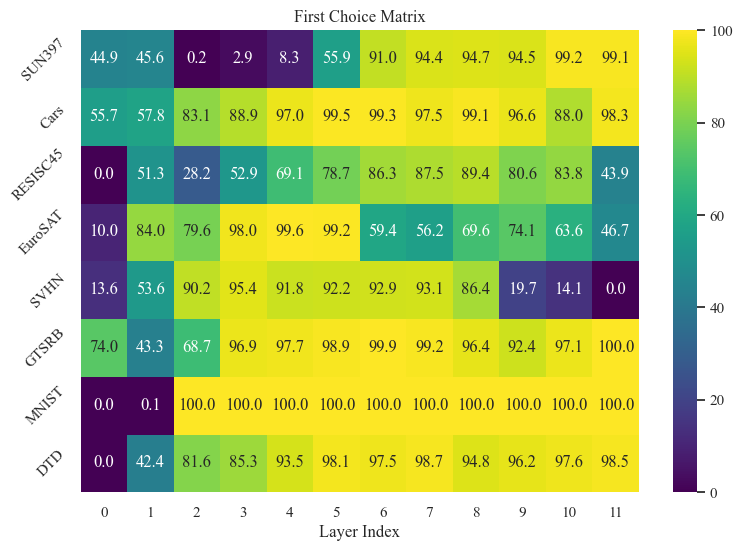

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax = cast(plt.Axes, ax)
sns.heatmap(
    first_choice_prob_matrix * 100, ax=ax, cmap="viridis", annot=True, fmt=".1f"
)
ax.set_xlabel("Layer Index")
ax.set_yticklabels(TEST_DATASET_LABELS, rotation=45)
plt.title("First Choice Matrix")
plt.savefig("first_choice_matrix.pdf", bbox_inches="tight")
plt.show()